In [1]:
import gpytorch
from LODEGP.LODEGP import LODEGP, list_standard_models
from helpers.plotting_functions import plot_single_input_gp_posterior
from helpers.training_functions import granso_optimization
import matplotlib.pyplot as plt
import numpy as np
import torch



In [2]:
list_standard_models()

['Bipendulum',
 'Bipendulum first equation',
 'Bipendulum second equation',
 'Bipendulum Parameterized',
 'No system',
 'Three tank',
 'Heating']

In [3]:
START = 2
END = 12
COUNT = 100
train_x = torch.linspace(START, END, COUNT)
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=3)

y0_func = lambda x: float(781/8000)*torch.sin(x)/x - float(1/20)*torch.cos(x)/x**2 + float(1/20)*torch.sin(x)/x**3
y1_func = lambda x: float(881/8000)*torch.sin(x)/x - float(1/40)*torch.cos(x)/x**2 + float(1/40)*torch.sin(x)/x**3
y2_func = lambda x: float(688061/800000)*torch.sin(x)/x - float(2543/4000)*torch.cos(x)/x**2 + float(1743/4000)*torch.sin(x)/x**3 - float(3/5)*torch.cos(x)/x**4 + float(3/5)*torch.sin(x)/x**5 
y0 = y0_func(train_x)
y1 = y1_func(train_x)
y2 = y2_func(train_x)
train_y = torch.stack([y0, y1, y2], dim=1)

model = LODEGP(train_x, train_y, likelihood, 3, ODE_name="Bipendulum", verbose=True, system_parameters={"l1": 1.0, "l2": 2.0})

D:[1 0 0]
[0 1 0]
V:[                                0                          -400/981                     x^2 + 981/200]
[                                0                          -200/981                 1/2*x^2 + 981/200]
[                               -1                  -400/981*x^2 - 4 x^4 + 2943/200*x^2 + 962361/20000]
[[0, -400/981, x^2 + 981/200], [0, -200/981, 1/2*x^2 + 981/200], [-1, -400/981*x^2 - 4, x^4 + 2943/200*x^2 + 962361/20000]]
ParameterDict(
    (signal_variance_2): Parameter containing: [torch.FloatTensor of size ]
    (lengthscale_2): Parameter containing: [torch.FloatTensor of size ]
)


In [4]:
loss_val, model, likelihood, log = granso_optimization(model, likelihood, train_x, train_y)

[Reinit] likelihood.raw_task_noises ← [-5.4624143  -8.542223   -0.07453863] (kernel: likelihood.raw_task_noises, dist: log, bounds: (0.0001, 1.0))
[Reinit] likelihood.raw_noise ← [-5.8577876] (kernel: likelihood.raw_noise, dist: log, bounds: (0.0001, 1.0))
[Reinit] model_parameters.signal_variance_2 ← -2.420776844024658 (kernel: LODE_Kernel, dist: log, bounds: (0.001, 10))
[Reinit] model_parameters.lengthscale_2 ← -4.610230445861816 (kernel: LODE_Kernel, dist: log, bounds: (0.001, 5.0))


/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/besginow/anaconda3/envs/sage3_129/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
LOG ERROR: Severe PyGRANSO issue. Loss is inf+0
LOG ERROR: Mat

In [5]:
model.eval()
likelihood.eval()
with torch.no_grad():
    test_x = torch.linspace(3, 4, 10)
    output = model(test_x)
    pred_y = likelihood(output)
print(output.mean)
print(output.covariance_matrix.diag().reshape(-1, 3))
print(pred_y.mean)
print(pred_y.covariance_matrix.diag().reshape(-1, 3))

print("====")
print(list(model.named_parameters()))

tensor([[ 0.0126,  0.0111,  0.1342],
        [ 0.0084,  0.0065,  0.0961],
        [ 0.0044,  0.0022,  0.0595],
        [ 0.0006, -0.0020,  0.0246],
        [-0.0030, -0.0058, -0.0083],
        [-0.0063, -0.0094, -0.0389],
        [-0.0093, -0.0126, -0.0670],
        [-0.0121, -0.0155, -0.0925],
        [-0.0145, -0.0180, -0.1152],
        [-0.0166, -0.0201, -0.1350]])
tensor([[2.2430e-06, 3.6368e-06, 1.5718e-04],
        [2.2386e-06, 3.5865e-06, 1.5695e-04],
        [2.2233e-06, 3.5121e-06, 1.5693e-04],
        [2.1950e-06, 3.4194e-06, 1.5653e-04],
        [2.1550e-06, 3.3156e-06, 1.5550e-04],
        [2.1066e-06, 3.2088e-06, 1.5383e-04],
        [2.0539e-06, 3.1072e-06, 1.5160e-04],
        [2.0013e-06, 3.0165e-06, 1.4910e-04],
        [1.9524e-06, 2.9412e-06, 1.4650e-04],
        [1.9101e-06, 2.8830e-06, 1.4404e-04]])
tensor([[ 0.0126,  0.0111,  0.1342],
        [ 0.0084,  0.0065,  0.0961],
        [ 0.0044,  0.0022,  0.0595],
        [ 0.0006, -0.0020,  0.0246],
        [-0.0030, -0

In [6]:
model_state_dict = model.state_dict()
model_state_dict

OrderedDict([('likelihood.raw_task_noises',
              tensor([-5.8046, -0.6545, -6.9493])),
             ('likelihood.raw_noise', tensor([-6.5607])),
             ('likelihood.raw_task_noises_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.raw_task_noises_constraint.upper_bound',
              tensor(inf)),
             ('likelihood.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.raw_noise_constraint.upper_bound', tensor(inf)),
             ('model_parameters.signal_variance_2', tensor(-5.4246)),
             ('model_parameters.lengthscale_2', tensor(0.6168)),
             ('covar_module.model_parameters.signal_variance_2',
              tensor(-5.4246)),
             ('covar_module.model_parameters.lengthscale_2', tensor(0.6168))])

tensor([[-1.6553e-02, -2.0131e-02, -1.3497e-01],
        [-1.7853e-02, -2.1440e-02, -1.4749e-01],
        [-1.8973e-02, -2.2544e-02, -1.5841e-01],
        [-1.9911e-02, -2.3444e-02, -1.6773e-01],
        [-2.0670e-02, -2.4140e-02, -1.7544e-01],
        [-2.1250e-02, -2.4636e-02, -1.8158e-01],
        [-2.1655e-02, -2.4936e-02, -1.8614e-01],
        [-2.1888e-02, -2.5045e-02, -1.8918e-01],
        [-2.1954e-02, -2.4970e-02, -1.9071e-01],
        [-2.1859e-02, -2.4718e-02, -1.9080e-01],
        [-2.1611e-02, -2.4297e-02, -1.8950e-01],
        [-2.1215e-02, -2.3716e-02, -1.8686e-01],
        [-2.0680e-02, -2.2986e-02, -1.8296e-01],
        [-2.0016e-02, -2.2117e-02, -1.7786e-01],
        [-1.9230e-02, -2.1121e-02, -1.7166e-01],
        [-1.8334e-02, -2.0009e-02, -1.6443e-01],
        [-1.7337e-02, -1.8792e-02, -1.5625e-01],
        [-1.6250e-02, -1.7484e-02, -1.4723e-01],
        [-1.5084e-02, -1.6097e-02, -1.3745e-01],
        [-1.3848e-02, -1.4642e-02, -1.2700e-01],
        [-1.2555e-02

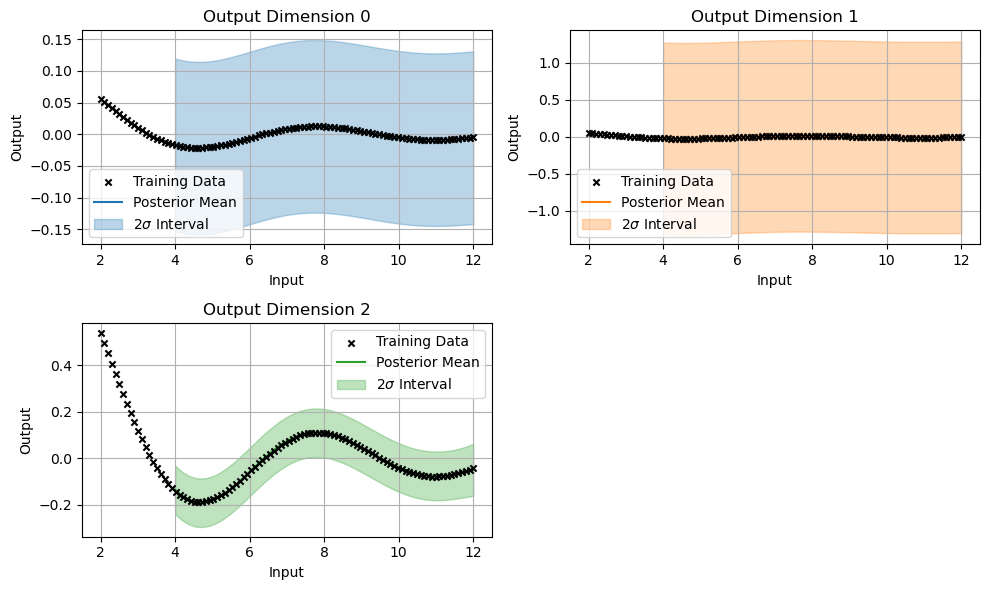

In [7]:
# Plot the posterior GP and the data
model.eval()
model.likelihood.eval()
with torch.no_grad():
    test_x = torch.linspace(4, 12, 100)
    observed_pred = model.likelihood(model(test_x))
    observed_pred_mean = observed_pred.mean
    observed_pred_var = observed_pred.covariance_matrix.diag().reshape(-1, 3)
    print(observed_pred_mean)
    print(observed_pred_var)
    plot_single_input_gp_posterior(train_x, train_y, test_x, observed_pred_mean, observed_pred_var, ncols=2)